## NGDS-Projekt - Gruppe J

Namen und E-Mail-Adressen der Gruppenmitglieder:

- Melanie Rohrbacher, <rohrbme1@students.zhaw.ch> 
- (Adriana Grabar, <grabaadr@students.zhaw.ch> --> leider aus dem Studium ausgetreten, siehe Mail vom Mi, 23.04.24)

Zugeteilte Wetterstation:  SCU

### Bibliotheken importieren und globaler Parameter definieren

In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.interpolate import make_interp_spline
from scipy.integrate import simps



### 1. Daten importieren und bereinigen

Importiert die Daten (Strings und Zahlen getrennt), wählt die relevanten Spalten und Zeilen aus und löscht fehlende Werte. Am Ende sollt ihr je ein Array für den Messzeitpunkt (in Tagen seit der ersten Messung) und die gemessenen Wetterdaten für eure Wetterstation haben.

In [40]:
# Daten aus der CSV-Datei laden
data = pd.DataFrame(pd.read_csv("Graubuenden.csv"))


# Filter for SCU station data
scu_data = data[data['stn'] == 'SCU'].copy()  # Kopie des DataFrames erstellen
scu_data.dropna(inplace=True)
scu_data['date_time'] = pd.to_datetime(scu_data['date_time'])
start_date = scu_data['date_time'].min()
scu_data['time_days'] = (scu_data['date_time'] - start_date).dt.total_seconds() / (60 * 60 * 24)

# Select relevant columns
selected_columns = ['stn', 'date_time', 'prestah0', 'tre200h0', 'rre150h0', 'su2000h0', 'time_days']
scu_data = scu_data[selected_columns]

# Reset index
scu_data.reset_index(drop=True, inplace=True)

# Anzahl der Werte für die Wetterstation "SCU" anzeigen
num_values_scu = len(scu_data)
print("Anzahl der Werte für die Wetterstation 'SCU':", num_values_scu)


# Ergebnis anzeigen
print("""
      
      Werte für die Wetterstation 'SCU':""")
scu_data

Anzahl der Werte für die Wetterstation 'SCU': 7453

      
      Werte für die Wetterstation 'SCU':


,stn,date_time,prestah0,tre200h0,rre150h0,su2000h0,time_days
0,SCU,2023-01-01 00:00:00,880.7,0.3,0.0,0.0,0.000000
1,SCU,2023-01-01 01:00:00,880.7,0.3,0.0,0.0,0.041667
2,SCU,2023-01-01 03:00:00,880.7,0.0,0.0,0.0,0.125000
3,SCU,2023-01-01 04:00:00,880.5,0.1,0.0,0.0,0.166667
4,SCU,2023-01-01 08:00:00,881.1,0.1,0.0,0.0,0.333333
...,...,...,...,...,...,...,...
7448,SCU,2023-12-31 19:00:00,861.3,-0.3,1.7,0.0,364.791667
7449,SCU,2023-12-31 20:00:00,862.5,0.0,3.4,0.0,364.833333
7450,SCU,2023-12-31 21:00:00,862.8,0.0,4.0,0.0,364.875000
7451,SCU,2023-12-31 22:00:00,863.1,-0.4,1.6,0.0,364.916667


### 2. Interpolation

Wir haben 15% der Zeilen in den Originaldaten gelöscht. Also gibt es nicht genau stündlich Messwerte.

Bestimmt eine Interpolationsfunktion für jede Messgrösse und interpoliert die Messreihen viertelstündlich (d.h. für jede Stunde vier Werte plus den Endpunkt am 1. Januar um 0:00).

Wählt die Art und den Grad der Interpolation so aus, dass die interpolierten Werte auch physikalisch sinnvoll sind.

In [53]:
# Create a new DataFrame with a datetime index every 15 minutes
interpolation_index = pd.date_range(start=scu_data['date_time'].min(), end=scu_data['date_time'].max(), freq='15T')
interpolated_data = pd.DataFrame(index=interpolation_index)

# Perform cubic interpolation for each measurement variable
for column in ['prestah0', 'tre200h0', 'rre150h0', 'su2000h0']:
    # Setup the interpolation function
    interp_func = interp1d(scu_data['date_time'].astype(np.int64), scu_data[column], kind='cubic', fill_value='extrapolate')
    # Apply the interpolation function
    interpolated_data[column] = interp_func(interpolation_index.astype(np.int64))

# Display the head of the interpolated data
print('Interpolated data head:')
print(interpolated_data.head())

Interpolated data head:
                       prestah0  tre200h0      rre150h0      su2000h0
2023-01-01 00:00:00  880.700000  0.300000  0.000000e+00  0.000000e+00
2023-01-01 00:15:00  880.685913  0.333156 -2.156305e-30 -7.035773e-04
2023-01-01 00:30:00  880.682924  0.341325 -2.613703e-30 -8.528209e-04
2023-01-01 00:45:00  880.688474  0.328832 -1.764249e-30 -5.756541e-04
2023-01-01 01:00:00  880.700000  0.300000  0.000000e+00  1.084202e-19


### 3. Daten und Interpolation darstellen und vergleichen 

Um die Interpolation zu überprüfen, stellt für alle Variablen jeweils die Daten und die Interpolationsfunktion zusammen grafisch dar.

Wählt dazu ein Zeitfenster von ein paar Tagen, in dem alle Variablen ein etwas interessantes Verhalten zeigen, d.h. es fällt Regen und die Sonne scheint.

Selected days for visualization: [datetime.date(2023, 3, 10) datetime.date(2023, 3, 14)
 datetime.date(2023, 4, 29)]


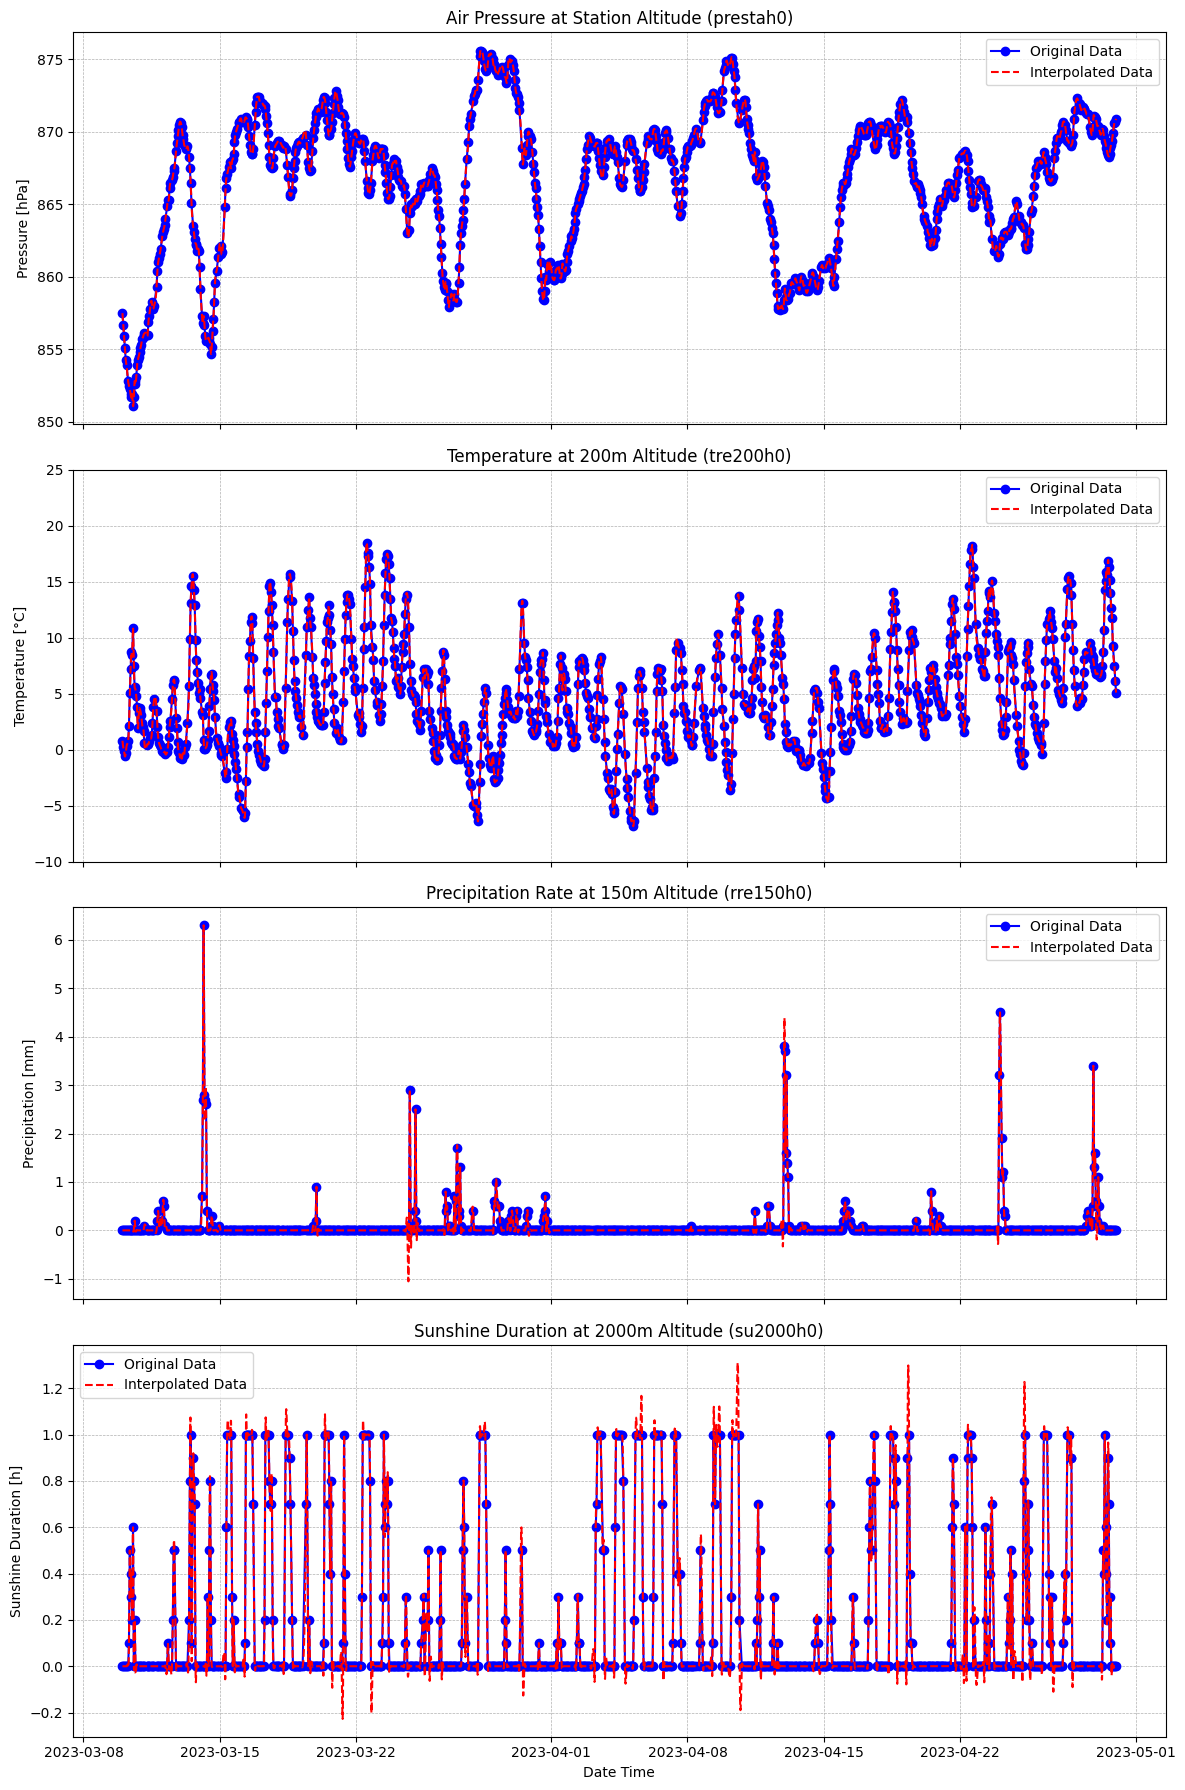

In [42]:
# Filter data to find days with both precipitation and sunshine
interesting_days = scu_data[(scu_data['rre150h0'] > 0) & (scu_data['su2000h0'] > 0)]['date_time'].dt.date.unique()

# Select a few interesting days for visualization
if len(interesting_days) > 3:
    selected_days = interesting_days[:3]  # Select the first three interesting days
else:
    selected_days = interesting_days

# Filter both original and interpolated data for the selected days
start_date = pd.to_datetime(selected_days[0])
end_date = pd.to_datetime(selected_days[-1]) + pd.Timedelta(days=1)  # Include the entire last day

original_data_filtered = scu_data[(scu_data['date_time'] >= start_date) & (scu_data['date_time'] <= end_date)]
interpolated_data_filtered = interpolated_data[(interpolated_data.index >= start_date) & (interpolated_data.index <= end_date)]

# Display the selected days for confirmation
print('Selected days for visualization:', selected_days)

# Adjusting the plot settings for better visualization
fig, axs = plt.subplots(4, 1, figsize=(12, 18), sharex=True)

# Titles and units for each subplot
variable_info = [
    ('Air Pressure at Station Altitude (prestah0)', 'Pressure [hPa]'),
    ('Temperature at 200m Altitude (tre200h0)', 'Temperature [°C]'),
    ('Precipitation Rate at 150m Altitude (rre150h0)', 'Precipitation [mm]'),
    ('Sunshine Duration at 2000m Altitude (su2000h0)', 'Sunshine Duration [h]')
]

# Plot each variable with appropriate y-axis label and settings
for i, (title, ylabel) in enumerate(variable_info):
    column_name = title.split('(')[1].split(')')[0]  # Extract the correct column name from the title
    axs[i].plot(original_data_filtered['date_time'], original_data_filtered[column_name], 'bo-', label='Original Data')
    axs[i].plot(interpolated_data_filtered.index, interpolated_data_filtered[column_name], 'r--', label='Interpolated Data')
    axs[i].set_title(title)
    axs[i].set_ylabel(ylabel)
    axs[i].legend()
    axs[i].grid(True, which='both', linestyle='--', linewidth=0.5)
    axs[i].set_axisbelow(True)

    # Specific settings for temperature plot
    if 'Temperature' in title:
        axs[i].set_ylim(-10, 25) 

# Set common labels
axs[3].set_xlabel('Date Time')
plt.tight_layout()
plt.show()

### 4. Nullstellen der Temperatur bestimmen

Wählt einen von ca. einer Woche, in der die Temperatur um Null herum schwankt. 

Bestimmt die Zeitpunkte, an denen die Temperatur den Wert Null hat. Nutzt dazu die Interpolationsfunktion der Temperatur aus Schritt 2.

Stellt die Temperatur und die Nullstellen zusammen grafisch dar.

Alternativ (und ein wenig schwieriger) könnt ihr auch einen Zeitraum wählen, in der die Temperatur hohe Werte erreicht. Bestimmt dann die Zeitpunkte, an denen die Temperatur einen bestimmten Hitzewert überschreitet, z.B. 30 Grad.

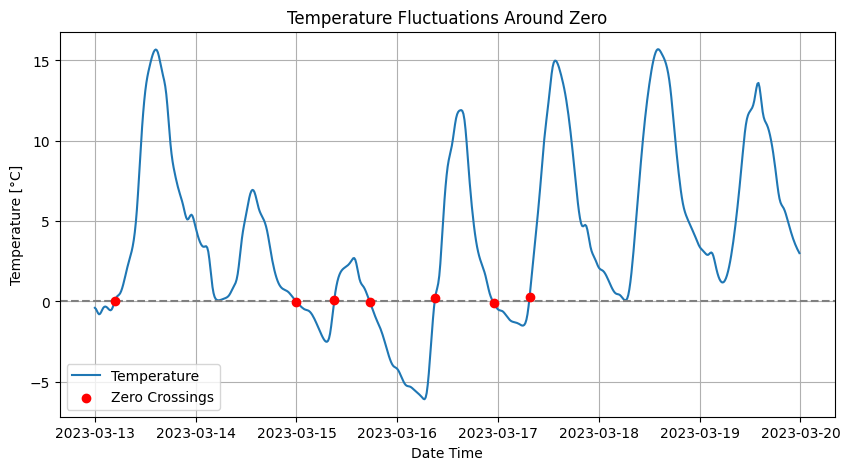

Selected week for analysis: 11
Zero crossing points: DatetimeIndex(['2023-03-13 04:45:00', '2023-03-15 00:00:00',
               '2023-03-15 09:00:00', '2023-03-15 17:30:00',
               '2023-03-16 09:00:00', '2023-03-16 23:00:00',
               '2023-03-17 07:30:00'],
              dtype='datetime64[ns]', freq=None)


In [43]:
# Ensure that selected_week_data is defined by filtering the interpolated data for the selected week
selected_week = interpolated_data_filtered.index.to_series().dt.isocalendar().week.mode()[0]  # Most common week in the data
selected_week_data = interpolated_data_filtered[interpolated_data_filtered.index.to_series().dt.isocalendar().week == selected_week]

# Now, find zero crossings
zero_crossings = selected_week_data['tre200h0'][1:].where(np.diff(np.sign(selected_week_data['tre200h0'])) != 0).dropna()

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(selected_week_data.index, selected_week_data['tre200h0'], label='Temperature')
plt.scatter(zero_crossings.index, zero_crossings, color='red', label='Zero Crossings', zorder=5)
plt.title('Temperature Fluctuations Around Zero')
plt.xlabel('Date Time')
plt.ylabel('Temperature [°C]')
plt.axhline(0, color='gray', linestyle='--')
plt.legend()
plt.grid(True)
plt.show()

print('Selected week for analysis:', selected_week)
print('Zero crossing points:', zero_crossings.index)

### 5. Grosse Schwankungen in Temperatur oder Luftdruck finden

Betrachtet entweder die Temperatur oder den Luftdruck übers ganze Jahr. Berechnet die Ableitung der gewählten Variable und stellt diese auch dar, um einen Zeitraum von ca. 1 Woche mit grossen Schwankungen zu finden.

In der gewählten Woche mit grossen Schwankungen sollen nun die Zeitpunkte bestimmt werden, zu denen die Temperatur bzw. der Luftdruck am stärksten steigt bzw. fällt, also das Maximum und das Minimum der Ableitung.

Um das Maximum/Minimum eines Arrays zu finden, könnt ihr die Funktionen [`np.argmax`](https://numpy.org/doc/stable//reference/generated/numpy.argmax.htm) und [`np.argmin`](https://numpy.org/doc/stable//reference/generated/numpy.argmin.html) verwenden. 

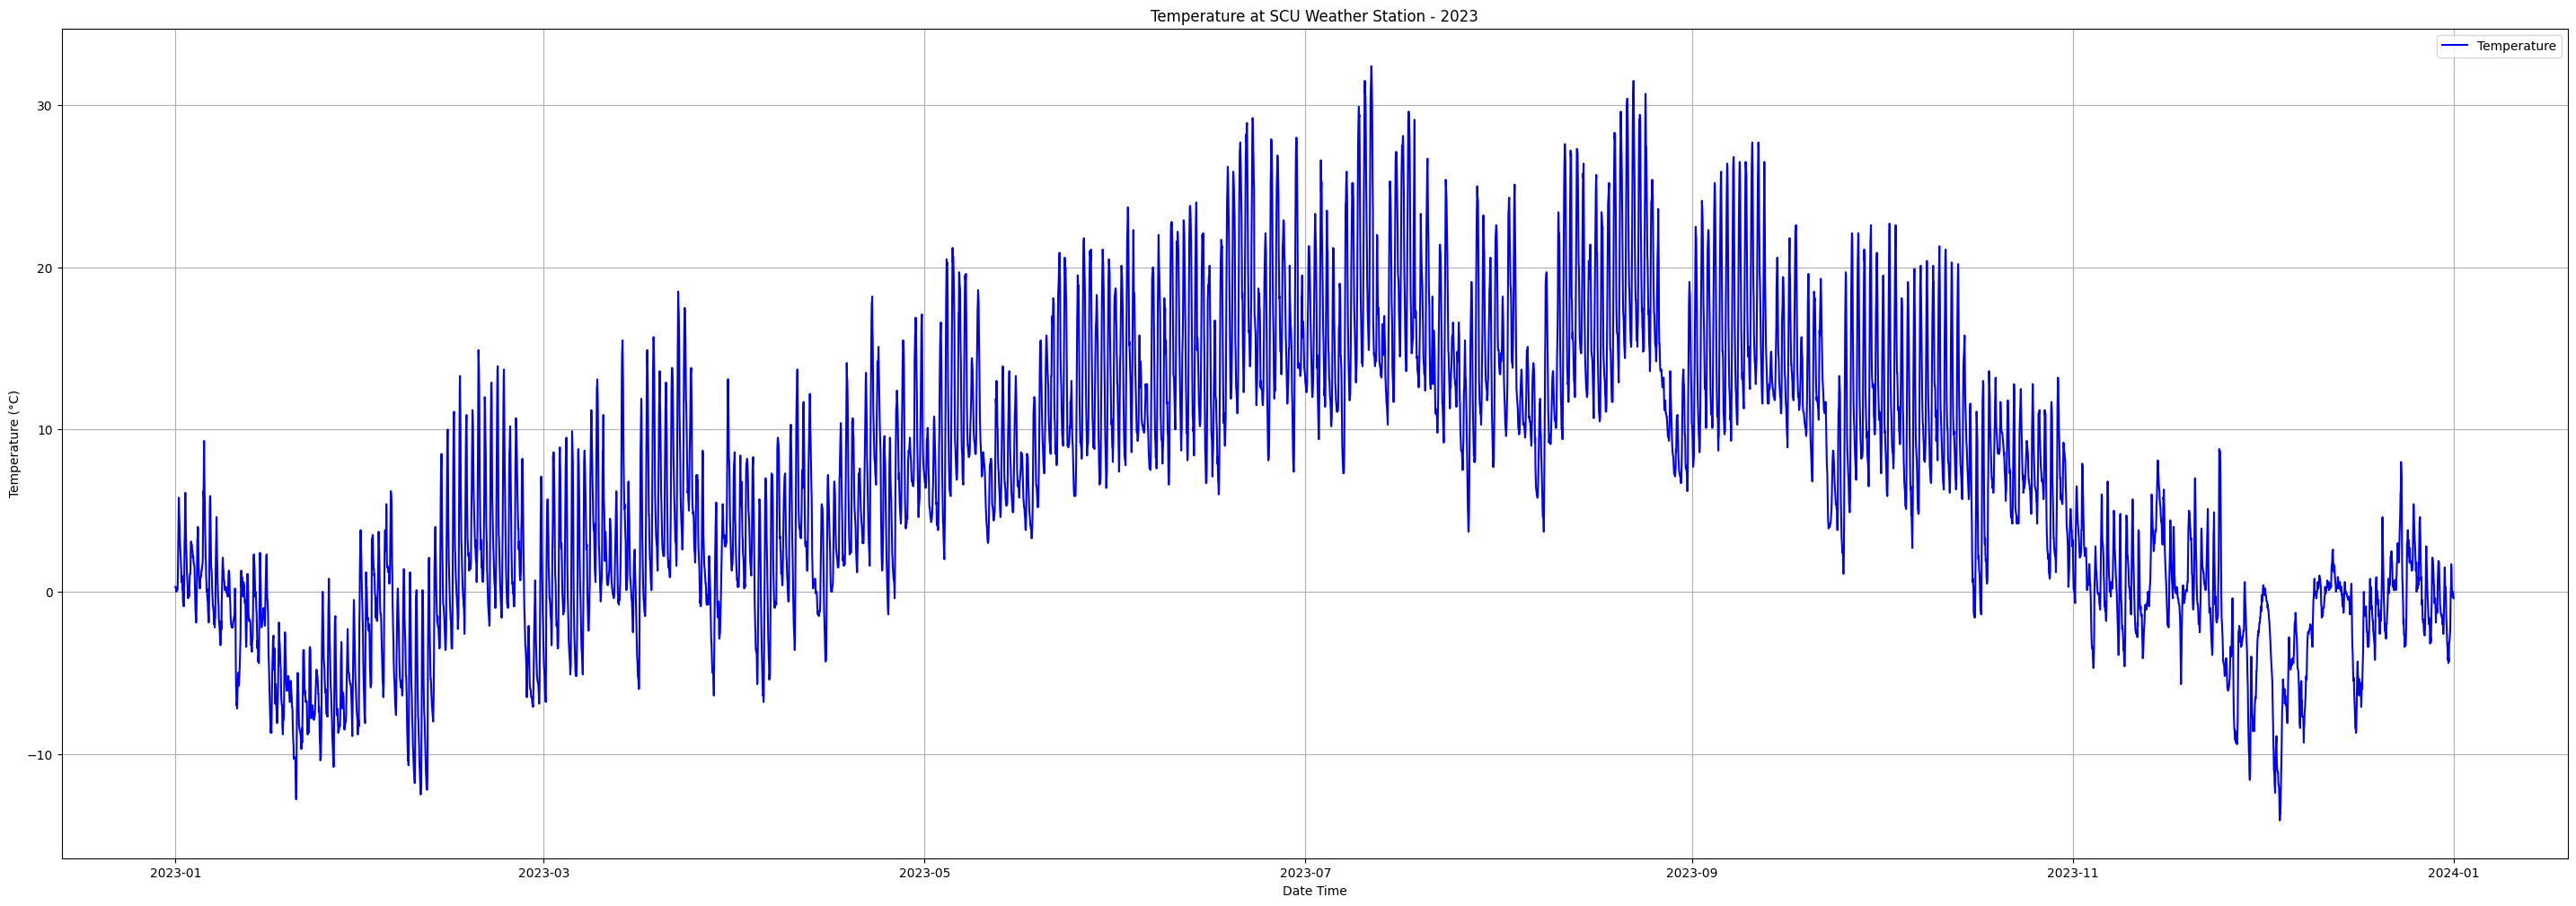

In [44]:
# Plotting the temperature for the SCU weather station over the year 2023
plt.figure(figsize=(36, 12))
plt.plot(scu_data['date_time'], scu_data['tre200h0'], label='Temperature', color='blue')
plt.title('Temperature at SCU Weather Station - 2023')
plt.xlabel('Date Time')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.grid(True)
plt.show()

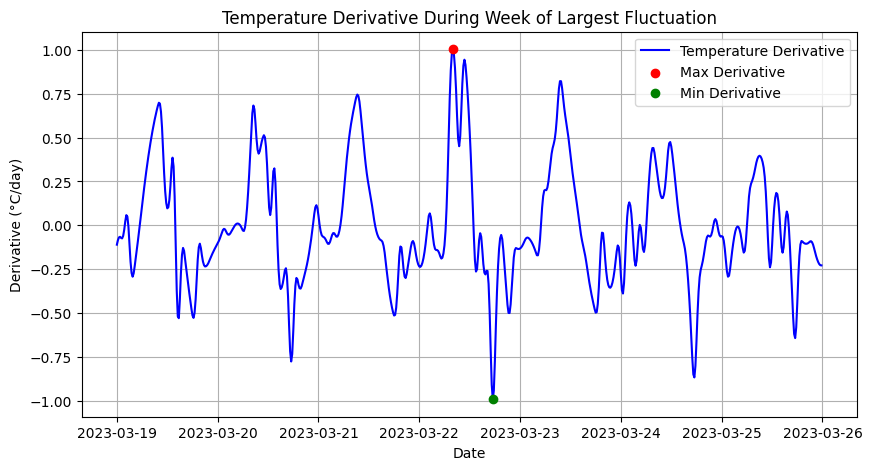

Week of largest fluctuations: 2023-03-19 00:00:00
Maximum derivative on: 2023-03-22 08:00:00
Minimum derivative on: 2023-03-22 17:30:00


In [45]:
# Calculate the derivative of temperature over the whole year
temperature_derivative = np.gradient(interpolated_data_filtered['tre200h0'])

# Convert to a pandas series for easier handling
temperature_derivative_series = pd.Series(temperature_derivative, index=interpolated_data_filtered.index)

# Identify the week with the largest fluctuations in the derivative
week_with_largest_fluctuations = temperature_derivative_series.abs().resample('W').mean().idxmax()

# Filter the data for the identified week
week_data = temperature_derivative_series[week_with_largest_fluctuations.strftime('%Y-%m-%d'): (week_with_largest_fluctuations + pd.Timedelta(days=6)).strftime('%Y-%m-%d')]

# Determine the points in time where the temperature rises or falls the most
max_derivative_idx = week_data.idxmax()
min_derivative_idx = week_data.idxmin()

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(week_data.index, week_data, label='Temperature Derivative', color='blue')
plt.scatter([max_derivative_idx], [week_data[max_derivative_idx]], color='red', label='Max Derivative', zorder=5)
plt.scatter([min_derivative_idx], [week_data[min_derivative_idx]], color='green', label='Min Derivative', zorder=5)
plt.title('Temperature Derivative During Week of Largest Fluctuation')
plt.xlabel('Date')
plt.ylabel('Derivative (°C/day)')
plt.legend()
plt.grid(True)
plt.show()

print('Week of largest fluctuations:', week_with_largest_fluctuations)
print('Maximum derivative on:', max_derivative_idx)
print('Minimum derivative on:', min_derivative_idx)

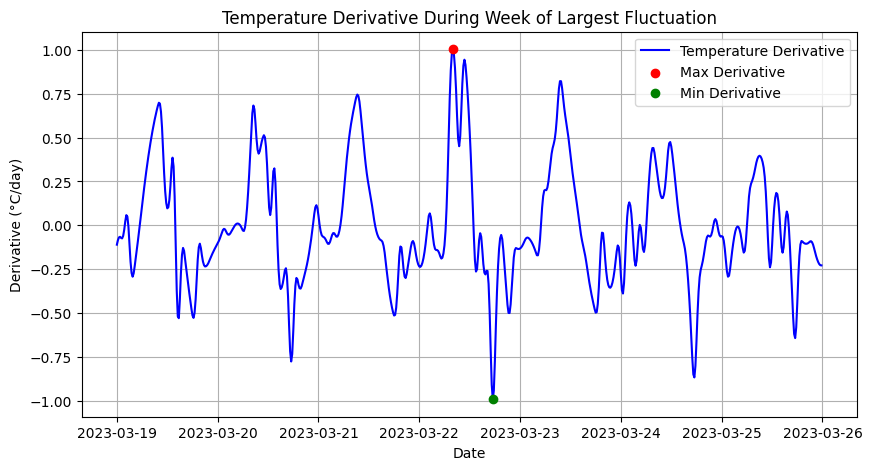

Week of largest fluctuations: 2023-03-19 00:00:00
Maximum derivative on: 2023-03-22 08:00:00
Minimum derivative on: 2023-03-22 17:30:00


In [46]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Calculate the derivative of temperature over the whole year
temperature_derivative = np.gradient(interpolated_data_filtered['tre200h0'])

# Convert to a pandas series for easier handling
temperature_derivative_series = pd.Series(temperature_derivative, index=interpolated_data_filtered.index)

# Identify the week with the largest fluctuations in the derivative
week_with_largest_fluctuations = temperature_derivative_series.abs().resample('W').mean().idxmax()

# Filter the data for the identified week
week_data = temperature_derivative_series[week_with_largest_fluctuations.strftime('%Y-%m-%d'): (week_with_largest_fluctuations + pd.Timedelta(days=6)).strftime('%Y-%m-%d')]

# Determine the points in time where the temperature rises or falls the most
max_derivative_idx = week_data.idxmax()
min_derivative_idx = week_data.idxmin()

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(week_data.index, week_data, label='Temperature Derivative', color='blue')
plt.scatter([max_derivative_idx], [week_data[max_derivative_idx]], color='red', label='Max Derivative', zorder=5)
plt.scatter([min_derivative_idx], [week_data[min_derivative_idx]], color='green', label='Min Derivative', zorder=5)
plt.title('Temperature Derivative During Week of Largest Fluctuation')
plt.xlabel('Date')
plt.ylabel('Derivative (°C/day)')
plt.legend()
plt.grid(True)
plt.show()

print('Week of largest fluctuations:', week_with_largest_fluctuations)
print('Maximum derivative on:', max_derivative_idx)
print('Minimum derivative on:', min_derivative_idx)

#### Analyzing temperature fluctuations

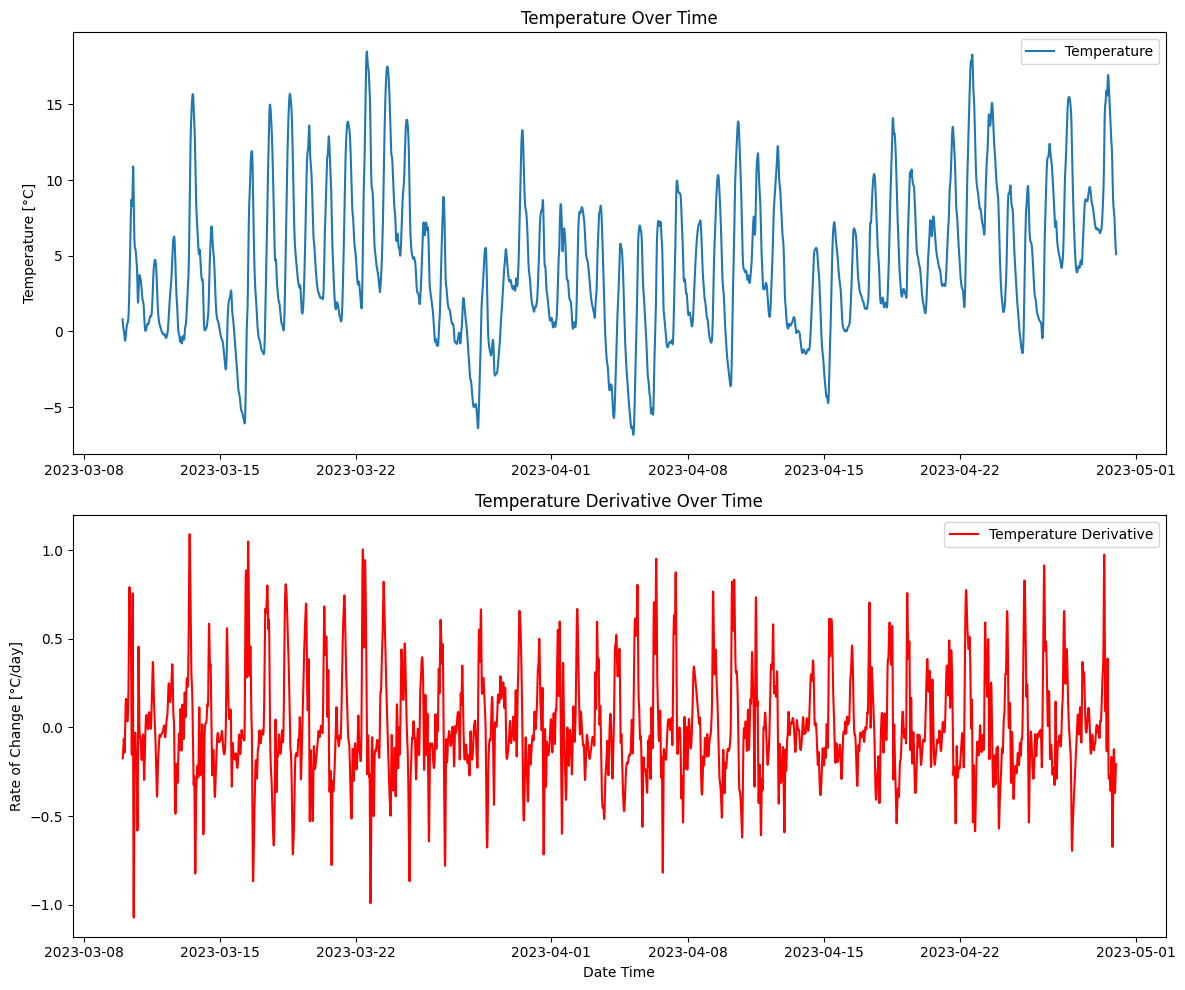

Week with largest temperature fluctuations: 2023-03-19 00:00:00
Maximum rate of change point: 2023-03-22 08:00:00
Minimum rate of change point: 2023-03-22 17:30:00


In [47]:
# Calculate the derivative of the temperature
temperature_derivative = np.gradient(interpolated_data_filtered['tre200h0'])

# Plotting the temperature and its derivative
fig, axs = plt.subplots(2, 1, figsize=(12, 10))
axs[0].plot(interpolated_data_filtered.index, interpolated_data_filtered['tre200h0'], label='Temperature')
axs[1].plot(interpolated_data_filtered.index, temperature_derivative, label='Temperature Derivative', color='red')
axs[0].set_title('Temperature Over Time')
axs[1].set_title('Temperature Derivative Over Time')
axs[0].set_ylabel('Temperature [°C]')
axs[1].set_ylabel('Rate of Change [°C/day]')
axs[1].set_xlabel('Date Time')
axs[0].legend()
axs[1].legend()
plt.tight_layout()
plt.show()

# Find the week with the largest fluctuations
week_derivative = pd.Series(temperature_derivative, index=interpolated_data_filtered.index).abs().resample('W').mean()
max_fluctuation_week = week_derivative.idxmax()

# Find max/min points in the selected week
selected_week_data = interpolated_data_filtered[max_fluctuation_week:max_fluctuation_week + pd.Timedelta(days=7)]
week_temperature_derivative = np.gradient(selected_week_data['tre200h0'])
max_point = selected_week_data.index[np.argmax(week_temperature_derivative)]
min_point = selected_week_data.index[np.argmin(week_temperature_derivative)]

print('Week with largest temperature fluctuations:', max_fluctuation_week)
print('Maximum rate of change point:', max_point)
print('Minimum rate of change point:', min_point)

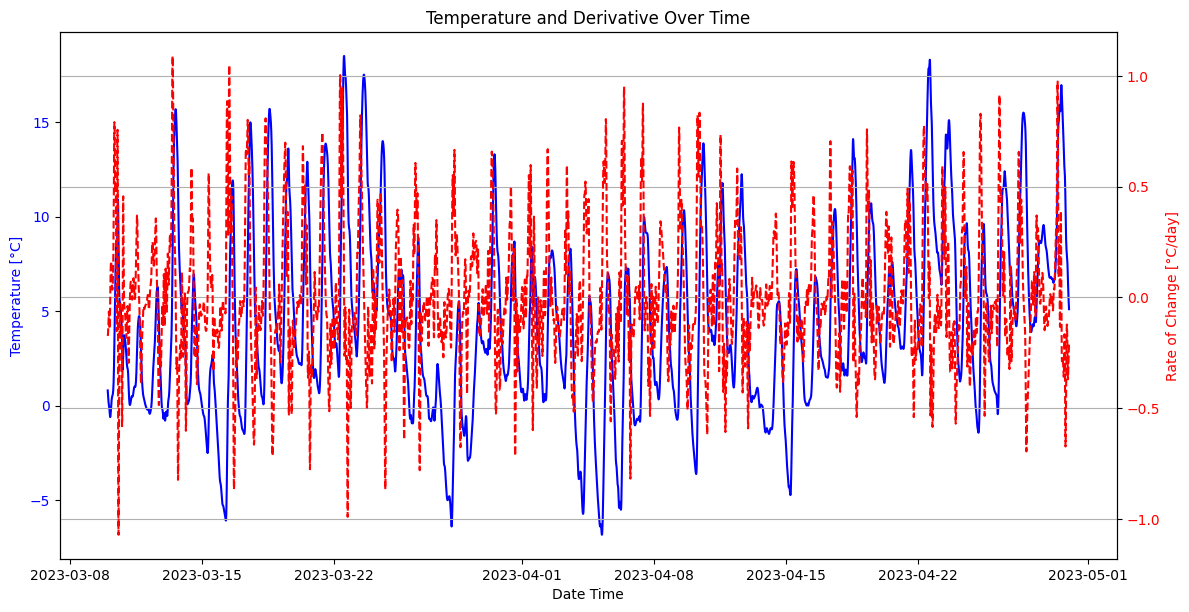

In [48]:
# Plotting temperature and its derivative on the same plot with background lines
fig, ax1 = plt.subplots(figsize=(12, 6))
ax1.plot(interpolated_data_filtered.index, interpolated_data_filtered['tre200h0'], label='Temperature', color='blue')
ax1.set_xlabel('Date Time')
ax1.set_ylabel('Temperature [°C]', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

ax2 = ax1.twinx()
ax2.plot(interpolated_data_filtered.index, temperature_derivative, label='Temperature Derivative', color='red', linestyle='--')
ax2.set_ylabel('Rate of Change [°C/day]', color='red')
ax2.tick_params(axis='y', labelcolor='red')

fig.tight_layout()
plt.title('Temperature and Derivative Over Time')
plt.grid(True)
plt.show()

#### Analyzing air pressure fluctuations

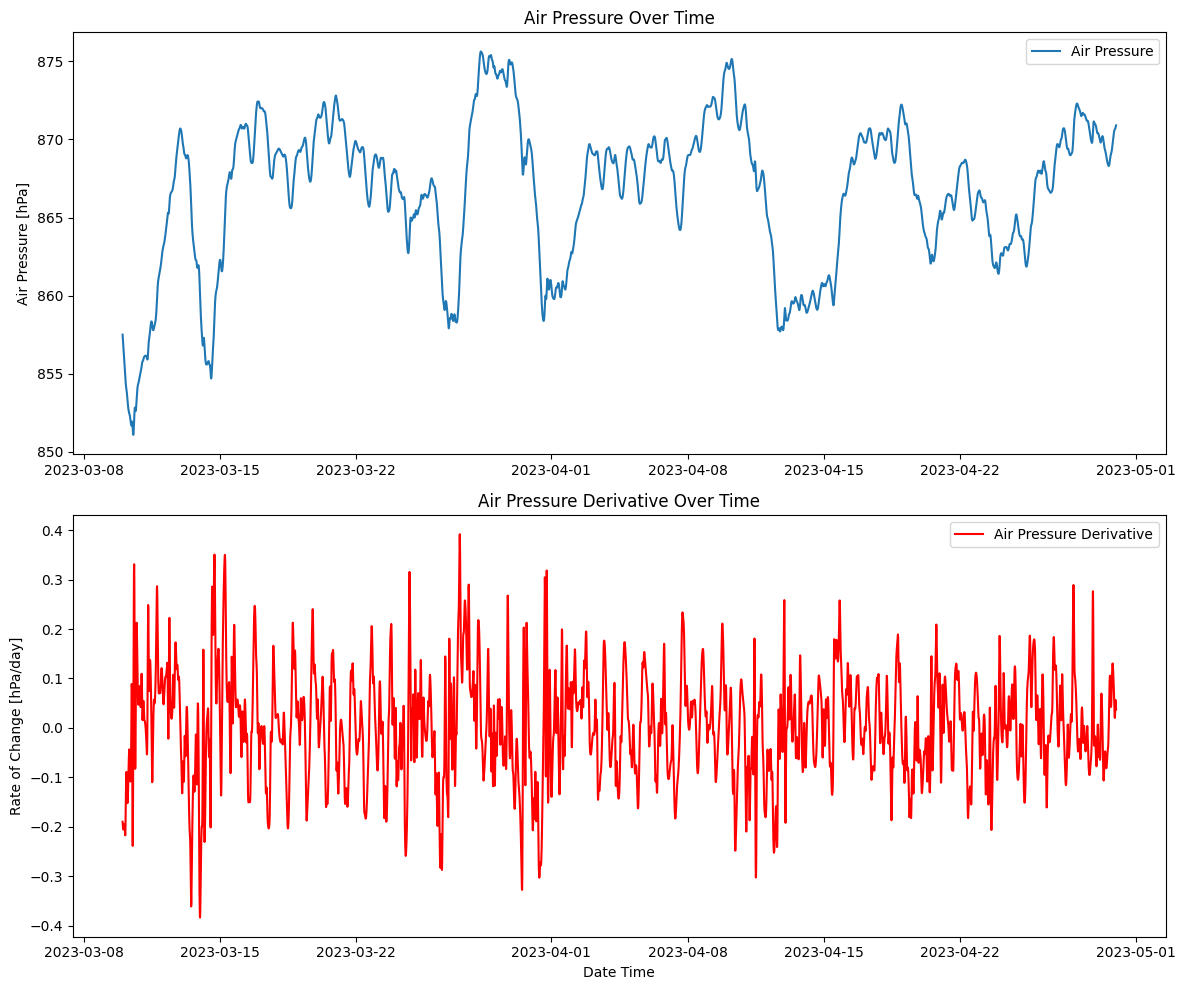

Week with largest air pressure fluctuations: 2023-04-02 00:00:00
Maximum rate of change point: 2023-04-07 17:45:00
Minimum rate of change point: 2023-04-07 09:00:00


In [49]:
# Calculate the derivative of the air pressure
air_pressure_derivative = np.gradient(interpolated_data_filtered['prestah0'])

# Plotting the air pressure and its derivative
fig, axs = plt.subplots(2, 1, figsize=(12, 10))
axs[0].plot(interpolated_data_filtered.index, interpolated_data_filtered['prestah0'], label='Air Pressure')
axs[1].plot(interpolated_data_filtered.index, air_pressure_derivative, label='Air Pressure Derivative', color='red')
axs[0].set_title('Air Pressure Over Time')
axs[1].set_title('Air Pressure Derivative Over Time')
axs[0].set_ylabel('Air Pressure [hPa]')
axs[1].set_ylabel('Rate of Change [hPa/day]')
axs[1].set_xlabel('Date Time')
axs[0].legend()
axs[1].legend()
plt.tight_layout()
plt.show()

# Find the week with the largest fluctuations
week_derivative = pd.Series(air_pressure_derivative, index=interpolated_data_filtered.index).abs().resample('W').mean()
max_fluctuation_week = week_derivative.idxmax()

# Find max/min points in the selected week
selected_week_data = interpolated_data_filtered[max_fluctuation_week:max_fluctuation_week + pd.Timedelta(days=7)]
week_air_pressure_derivative = np.gradient(selected_week_data['prestah0'])
max_point = selected_week_data.index[np.argmax(week_air_pressure_derivative)]
min_point = selected_week_data.index[np.argmin(week_air_pressure_derivative)]

print('Week with largest air pressure fluctuations:', max_fluctuation_week)
print('Maximum rate of change point:', max_point)
print('Minimum rate of change point:', min_point)

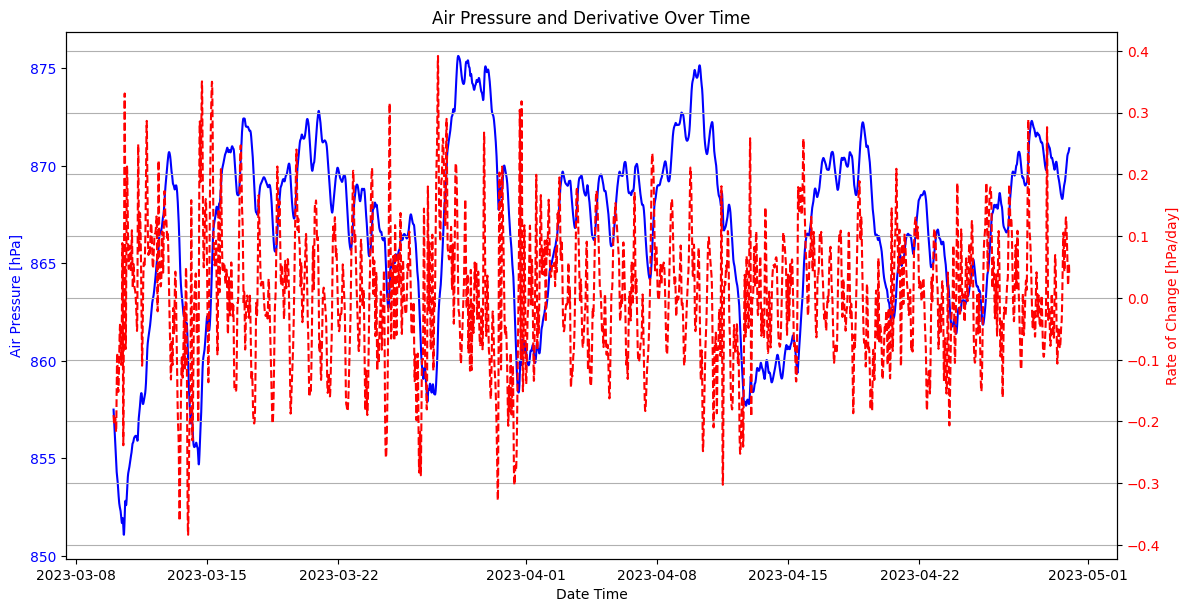

In [50]:
# Plotting air pressure and its derivative on the same plot with background lines
fig, ax1 = plt.subplots(figsize=(12, 6))
ax1.plot(interpolated_data_filtered.index, interpolated_data_filtered['prestah0'], label='Air Pressure', color='blue')
ax1.set_xlabel('Date Time')
ax1.set_ylabel('Air Pressure [hPa]', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

ax2 = ax1.twinx()
ax2.plot(interpolated_data_filtered.index, air_pressure_derivative, label='Air Pressure Derivative', color='red', linestyle='--')
ax2.set_ylabel('Rate of Change [hPa/day]', color='red')
ax2.tick_params(axis='y', labelcolor='red')

fig.tight_layout()
plt.title('Air Pressure and Derivative Over Time')
plt.grid(True)
plt.show()

### 6. Mittelwerte berechnen

Wählt eine der Messgrössen aus und berechnet den Mittelwert über das ganze Jahr und den Mittelwert pro Monat. Der Einfachheit halber könnt ihr den Monat als 1/12 des Jahres definieren.

Stellt die eigentliche Variable und die Mittelwerte zusammen grafisch dar.

Die Mittelung soll mithilfe der Integration über die Interpolationsfunktion aus Schritt 2 berechnet werden.

Bei der Integration kann es Warnungen geben, da die Interpolationsfunktionen teils stark schwanken. Es kann hilfreich sein, mit dem Parameter `limit` die Anzahl Subintervalle zu erhöhen. Probiert aus, ab wann sich das Resultat nicht mehr gross ändert.

*Emphehlungen:* 
- Implementiert dies zuerst für die Temperatur, da diese am einfachsten zu interpretieren ist. Dann könnt ihr immer noch die anderen Messgrössen betrachten.
- Beginnt mit dem Mittelwert über das ganze Jahr, dann verallgemeinert für ein beliebiges Zeitintervall und iteriert schliesslich über die Monate.

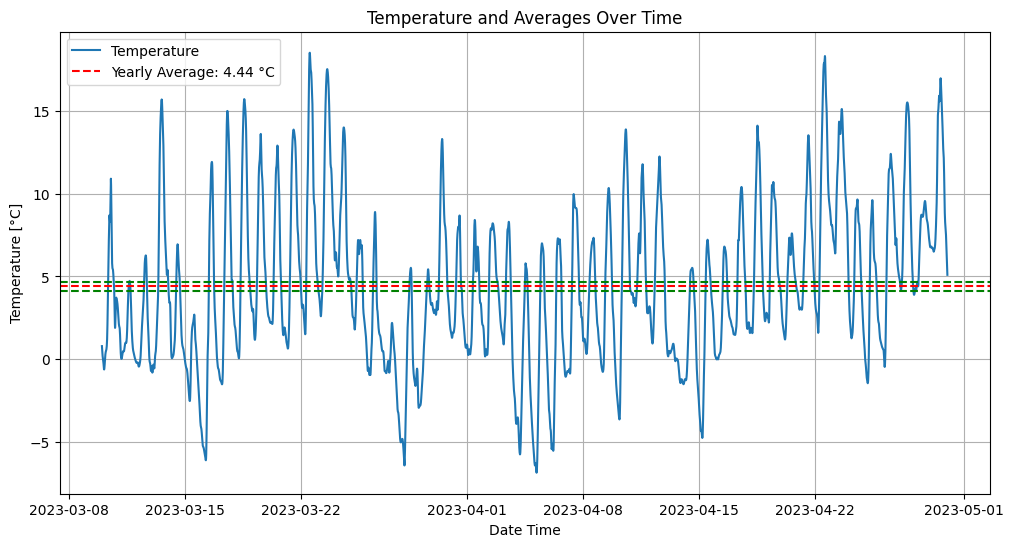

In [51]:
# Define the time points for integration
x_points = np.arange(0, len(interpolated_data_filtered), 1)

# Calculate the yearly average temperature using Simpson's rule
yearly_average_temp = simps(interpolated_data_filtered['tre200h0'], x_points) / len(interpolated_data_filtered)

# Calculate monthly averages
monthly_averages = []
for month in range(1, 13):
    month_data = interpolated_data_filtered[interpolated_data_filtered.index.month == month]
    if not month_data.empty:
        x_points_month = np.arange(0, len(month_data), 1)
        monthly_average = simps(month_data['tre200h0'], x_points_month) / len(month_data)
    else:
        monthly_average = None # Assign None if no data is available
    monthly_averages.append(monthly_average)

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(interpolated_data_filtered.index, interpolated_data_filtered['tre200h0'], label='Temperature')
plt.axhline(y=yearly_average_temp, color='r', linestyle='--', label=f'Yearly Average: {yearly_average_temp:.2f} °C')
for i, avg in enumerate(monthly_averages):
    if avg is not None:
        plt.axhline(y=avg, color='g', linestyle='--', label=f'Month {i+1} Average: {avg:.2f} °C' if i == 0 else '')
plt.title('Temperature and Averages Over Time')
plt.xlabel('Date Time')
plt.ylabel('Temperature [°C]')
plt.legend()
plt.grid(True)
plt.show()

In [52]:
def mean_func(func, a, b):
    integral, _ = quad(func, a, b, limit=10*3)

    return integral / (b - a)

mean_temp_year = mean_func(t_spline, 0, 365)
print(mean_temp_year)



# Mittelwert für jeden Monat berechnen
def mean_monthly(func, total_days=365):
    mean_monthly_temperatures = []
    days_per_month = total_days // 12

    for month in range(12):
        start_day = month * days_per_month
        end_day = start_day + days_per_month
        mean_temp_month = mean_func(func, start_day, end_day)
        mean_monthly_temperatures.append(mean_temp_month)

    return mean_monthly_temperatures

# Berechnung des Mittelwerts für jeden Monat
mean_monthly_temperatures = mean_monthly(t_spline)

# Grafische Darstellung der monatlichen Mittelwerte
plt.figure(figsize=(20, 5))
plt.plot(range(1, 13), mean_monthly_temperatures, marker='o', label=f"Monatliche Mitteltemperatur")
plt.axhline(y=mean_temp_year, color='r', linestyle='--', label=f'Jahresmittelwert {round(mean_temp_year, 2)}°C')
plt.title('Monatliche Mittelwerte der Temperatur')
plt.xlabel('Monat')
plt.ylabel('Mittelwert der Temperatur')
plt.xticks(range(1, 13))
plt.grid()
plt.legend()
plt.show()

# Ausgabe der Mittelwerte für jeden Monat + Jahr
for month, mean_temp in enumerate(mean_monthly_temperatures):
    print(f"Mittelwert für Monat {month}:", round(mean_temp, 2))

print("Mittelwert über das ganze Jahr:", round(mean_temp_year, 2))

NameError: name 't_spline' is not defined

### 7. Glättung (Gleitendes Mittel) bestimmen

Nehmt die gleiche Messgrösse wie in Schritt 6 und berechnet das gleitende Mittel über das ganze Jahr. Dazu soll die Faltung mit einer symmetrischen Rechteckfunktion verwendet werden. Die Fensterbreite (Breite des Rechtecks) soll ein Parameter sein, den ihr variieren könnt.

Stellt die Messgrösse und das gleitende Mittel mit Fensterbreite = 1 Woche zusammen dar. Optional könnt ihr dazu auch noch das gleitende Mittel mit Fensterbreite = 1 Monat darstellen.

*Vorsicht:* Die Faltung ist rechenintensiv. Berechnet also zuerst das gleitende Mittel an wenigen Zeitpunkten über das ganze Jahr, z.B. 100, und erhöht dann die Anzahl Zeitpunkte vorsichtig.

### Zusammenfassung

### Reflexion

Mitglied 1: Melanie Rohrbacher
- Was hat gut funktioniert?
    - Aufgabenverteilung und Kommunikation zueinander (für die ersten paar Wochen)

- Was hat nicht gut funktioniert?
    - Der Kampf, die Grafik so darzustellen, wie ich es im Kopf haben wollte
    - Den Überblick bei all den Daten zu behalten, nach jeder Arbeitssitzung ist es oft notwendig, sich erneut zu informieren und weiter zu recherchieren.

- Was würdest du beim nächsten Mal anders machen?
    - Mehr Zeit für die Aufgaben einplanen 

- Was hast du gelernt?
    - Dass Python ein mächtiges Tool ist, welches ich noch nicht vollständig beherrsche
    - Generell alle Themen des Moduls sind mir neu (ausserhalb des Unterrichts noch nie was von Interpolation gehört)
    - Verküpfte Arbeitsweise zwischen dem Aufgabenmaterial im Unterricht und besseres prompting ChatGPT
    - ChatGPT und andere KI-Tools werden zukünftig diese Arbeit vollständig übernehmen, doch bis jetzt ist es noch nicht so ausgereift und fehlerhaft
    

- Was war die grösste Herausforderung?
    - Die Sache irgendwie allein durchzuboxen 
    - Durchhaltevermögen beim Debuggen. (Zerrt an den Nerven.)
- usw.
